__<h2>THE MAIN POINT:</h2>__
<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">
<p style="padding: 10px;color:white;">
I basically tried to do it the normal way, though there may be mistakes. Don't make the mistake of giving me advice.
</p>
</div>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd
import seaborn as sns
import os
from mpl_toolkits.axes_grid1 import ImageGrid



from sklearn import *
from sklearn.utils import shuffle
import cv2
from sklearn.metrics import classification_report,plot_confusion_matrix,confusion_matrix,ConfusionMatrixDisplay,roc_curve,RocCurveDisplay,precision_recall_curve,PrecisionRecallDisplay

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import *
import tensorflow as tf
from tensorflow import *
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.applications import VGG16,EfficientNetB0,EfficientNetB1
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">
<p style="padding: 10px;color:white;">
Converted to dataframe from row image.
</p>
</div>

In [2]:
dataset_path = Path('../input/pistachio-image-dataset')
images_link = list(dataset_path.glob(r'**/*.jpg'))
images_name = [x.parents[0].stem for x in images_link]
images_labels=preprocessing.LabelEncoder().fit_transform(images_name)

df=pd.DataFrame()
df['Link']=images_link
df['Name']=images_name
df['Label']=images_labels

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">
<p style="padding: 10px;color:white;">
Plotting, ratio of image .class and images
</p>
</div>

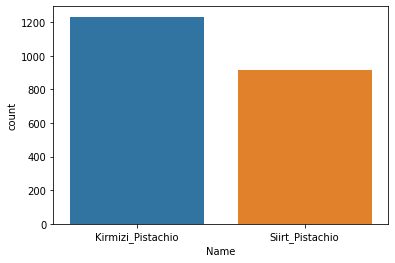

In [3]:
plt.figure(figsize=(6,4))
sns.countplot(x=df.Name,data=df)
plt.show()

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">
<p style="padding: 10px;color:white;">
Split train,test,validation data and ratio 8:1:1 
</p>
</div>

In [4]:
!pip install split_folders
import splitfolders
image_path=Path('../input/pistachio-image-dataset/Pistachio_Image_Dataset/Pistachio_Image_Dataset')
splitfolders.ratio(image_path, output="output", seed=101, ratio=(.8, .1, .1))

Copying files: 2148 files [00:12, 170.10 files/s]


<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">
<p style="padding: 10px;color:white;">
Image preprocessing with keras image generator
</p>
</div>

In [5]:
def img_Generator(file_name,gen_type):
    if gen_type=='yes':
        generet_Data=ImageDataGenerator(rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')
        gen_data=generet_Data.flow_from_directory(file_name,target_size=(224, 224),
                                                  batch_size=32,shuffle=True,
                                                  class_mode='binary')
                
    else:
        generet_Data1=ImageDataGenerator()
        gen_data=generet_Data1.flow_from_directory(file_name,target_size=(224, 224),
                                                  batch_size=32,shuffle=False,
                                                  class_mode='binary')
    
    return gen_data

data_typ='yes'
train_data=img_Generator('./output/train/',data_typ)
data_typ='no'
test_data=img_Generator('./output/test/',data_typ)
data_typ='no'
val_data=img_Generator('./output/val/',data_typ)

Found 1717 images belonging to 2 classes.
Found 217 images belonging to 2 classes.
Found 214 images belonging to 2 classes.


<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">
<p style="padding: 10px;color:white;">
Model train and test with EfficientNetB0
</p>
</div>

In [6]:
model = EfficientNetB0(
      input_shape = (224, 224,3),
      include_top = False,
      weights = 'imagenet'
    )
mdl=model.output
mdl=GlobalAveragePooling2D()(mdl)
mdl=Flatten()(mdl)
mdl=Dropout(0.5)(mdl)
mdl=Dense(1,activation = "sigmoid")(mdl)
model=keras.Model(model.input,mdl)


model.compile(loss = "binary_crossentropy", 
              optimizer = "adam", 
              metrics = "accuracy")

tensorboard = TensorBoard(log_dir="logs")

early_stp=EarlyStopping(monitor='val_accuracy',
                        mode='max', 
                        verbose=1, 
                        patience=20)
checkpoint = ModelCheckpoint('model.h5', 
                             monitor='val_accuracy', 
                             mode='max',
                             verbose=1,
                             save_best_only=True )

reduce_LR = ReduceLROnPlateau(monitor="val_accuracy", 
                             factor = 0.3, 
                             patience = 2, 
                             min_delta=0.001, 
                             mode = "auto", 
                            verbose = 1)

History = model.fit_generator(train_data,
                              validation_data=val_data,
                              epochs=10,verbose=1,
                              callbacks=[checkpoint,early_stp,tensorboard,reduce_LR])

16719872/16705208 [==============================] - 0s 0us/step


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/10
54/54 [==============================] - 46s 578ms/step - loss: 0.2074 - accuracy: 0.9068 - val_loss: 0.5239 - val_accuracy: 0.8037

Epoch 00001: val_accuracy improved from -inf to 0.80374, saving model to model.h5
Epoch 2/10
54/54 [==============================] - 29s 536ms/step - loss: 0.0888 - accuracy: 0.9709 - val_loss: 0.2944 - val_accuracy: 0.9159

Epoch 00002: val_accuracy improved from 0.80374 to 0.91589, saving model to model.h5
Epoch 3/10
54/54 [==============================] - 29s 530ms/step - loss: 0.0659 - accuracy: 0.9761 - val_loss: 0.0966 - val_accuracy: 0.9720

Epoch 00003: val_accuracy improved from 0.91589 to 0.97196, saving model to model.h5
Epoch 4/10
54/54 [==============================] - 29s 535ms/step - loss: 0.0802 - accuracy: 0.9715 - val_loss: 0.0583 - val_accuracy: 0.9860

Epoch 00004: val_accuracy improved from 0.97196 to 0.98598, saving model to model.h5
Epoch 5/10
54/54 [==============================] - 29s 535ms/step - loss: 0.0566 - acc

__<center><h2>Model Avaluate</h2></center>__

In [7]:
model.evaluate(test_data)

7/7 [==============================] - 1s 167ms/step - loss: 0.0212 - accuracy: 0.9908


[0.02116137556731701, 0.9907833933830261]

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">
<p style="padding: 10px;color:white;">
Finally plotting confusion matrix and others reports.
</p>
</div>

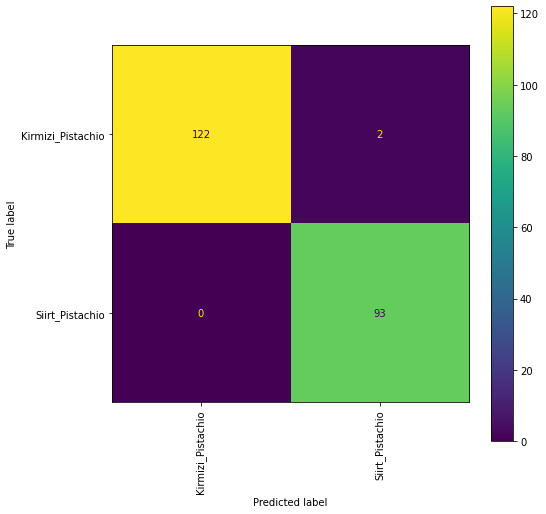

In [8]:
y_val = test_data.classes
y_pred = model.predict(test_data)
y_pred1 = ((y_pred > 0.5)+0).ravel()
cm = confusion_matrix(y_val,y_pred1)
cmp = ConfusionMatrixDisplay(cm,display_labels = ['Kirmizi_Pistachio', 'Siirt_Pistachio'])
fig, ax = plt.subplots(figsize=(8,8))
cmp.plot(ax=ax, xticks_rotation=90)

__Reports of classification__

In [9]:
print(classification_report(y_val,y_pred1))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       124
           1       0.98      1.00      0.99        93

    accuracy                           0.99       217
   macro avg       0.99      0.99      0.99       217
weighted avg       0.99      0.99      0.99       217



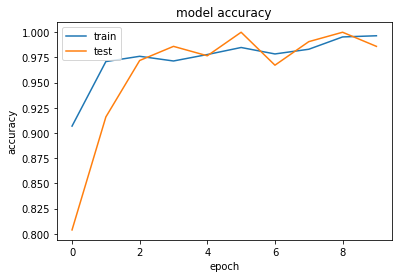

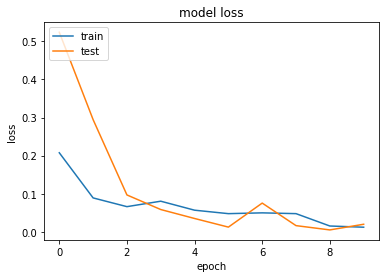

In [10]:
# summarize history for accuracy
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

__Data Frame for Plotting__

In [11]:
Link_data=[]
Name_Cls=[]
for i in test_data.filepaths:
    unq_name=i.split('/')[3]
    Name_Cls.append(unq_name)
    Link_data.append(i)
df_plot=pd.DataFrame()
df_plot['Link']=Link_data
df_plot['Name']=Name_Cls

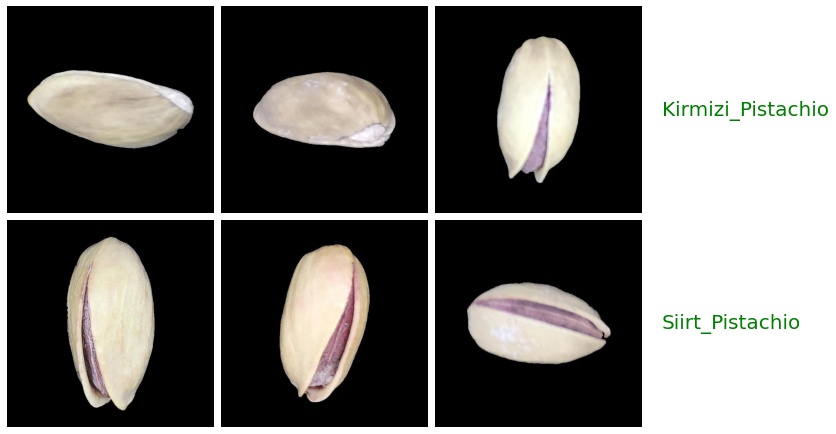

In [12]:
fig = plt.figure(1, figsize=(25, 25))
grid = ImageGrid(fig,121, nrows_ncols=(2, 3), axes_pad=0.10)
i = 0
for category_id, category in enumerate(df_plot.Name.unique()):
    for filepath in df_plot[df_plot['Name'] == category]['Link'].values[:3]:
        ax = grid[i]
        img = cv2.imread(filepath)
        img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img/255)
        ax.axis('off')
        if i % 3 == 3 - 1:
            ax.text(660, 300, category, verticalalignment='center',fontsize=20,color = 'green')
        
            
        i+=1
    
plt.show();

__<h2>Conclusion:</h2>__
<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:#5642C5;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">

<p style="padding: 10px;color:white;">
If you have any suggestion, please do it.
</p>
</div>